# <center>Estimating mean profiles and fluxes in high-speed turbulent boundary layers using inner/outer-layer transformations</center>

             Created on: July 6, 2023
           Developed by: Rene Pecnik (r.pecnik@tudelft.nl)
                         Asif M. Hasan (a.m.hasan@tudelft.nl)
                         Process & Energy Department, Faculty of 3mE
                         Delft University of Technology, the Netherlands.

       Last modified on: July 10, 2023 (Rene Pecnik) 


The following python code in this notebook is based on the publication: https://doi.org/10.48550/arXiv.2307.02199.


This is the bibtex entry in case you use the code: 

    @article{hasan2023estimating,
      title={Estimating mean profiles and fluxes in high-speed turbulent boundary layers using inner/outer-layer transformations},
      author={Hasan, Asif Manzoor and Larsson, Johan and Pirozzoli, Sergio and Pecnik, Rene},
      journal={arXiv preprint arXiv:2307.02199},
      year={2023}
    }

# Main source code
<br>
<hr style="border:0.5px solid black">


## Mean velocity profile
The mean velocity is obtained by 

$$ \bar u^+ = 
\int_{0}^{\delta^+} 
\left[\vphantom{\frac{1}{2}}\right.
\underbrace{\frac{\mu_w}{\bar \mu + \mu_t}}_{\text{Law of the wall}}
+  
\underbrace{\frac{\sqrt{\rho_w/\bar\rho}}{Re_\tau} \, \frac{\Pi}{\kappa} \, \pi\, \sin \left(\pi \frac{y}{\delta}\right)}_{\text{Law of the wake}}
\left.\vphantom{\frac{1}{2}}\right]
dy^+, $$

with the Johnson-King eddy eddy viscosity model, defined as 

$$\mu_t = \kappa \bar\mu y^* D(M_\tau), $$

and the modified van Driest damping function

$$ D(M_{\tau}) = \left[1 - \mathrm{exp}\left({\frac{-y^*}{A^+ + f(M_\tau)}}\right)\right]^2. $$

The constants and the function to account for intrinsic compressiblity effects in $D$ are given as

$$A^+ = 17,~\kappa=0.41,~\text{and}~f(M_\tau)=19.3M_\tau,~\text{where}~M_\tau=u_{\tau,w}/a_w .$$

The wake parameter is obtained by 

$${\Pi} = 0.69\,\left[1 - \exp(-0.243 \sqrt{z} - {0.15} \,z)\right],$$
with
$$z = Re_\theta/425 - 1.$$

In [1]:
def meanVelocity(ReTheta, ReTau, MTau, y_ye, r_rw, mu_muw, kappa, Apl):
    
    # Semi-local Reynolds number and scaled wall distances 
    ReTauSt = ReTau*np.sqrt(r_rw)/mu_muw
    ypl     = y_ye*ReTau
    yst     = y_ye*ReTauSt
    
    # eddy viscosity model
    D    = (1-np.exp(-yst/(Apl + 19.3*MTau)))**2
    mut  = kappa*mu_muw*yst*D
    
    # wake parameter
    z1   = ReTheta/425-1
    Pi   = 0.69*(1 - np.exp(-0.243*z1**0.5 - 0.150*z1))
    Wake = Pi/kappa*np.pi*np.sin(np.pi*y_ye)
    
    # velocity 
    upl  = cumtrapz(1/(mu_muw + mut) + 1/ReTau/np.sqrt(r_rw)*Wake, ypl, initial=0)
    
    upl_inf = upl[-1]/0.99 # calculate upl_inf

    return ypl, yst, upl, upl_inf

## Temperature-velocity relationship (Zhang et al. (2014), JFM)

$$\frac{\bar T}{T_w} =1+\frac{T_r-T_w}{T_w} \left[(1-sPr)\left(\frac{\bar u}{u_\infty}\right)^2+s \, {Pr}\left(\frac{\bar u}{u_\infty}\right)\right]+\frac{T_\infty-T_r}{T_w}\left(\frac{\bar u}{u_\infty}\right)^2,$$

where 
$$T_r/T_\infty = 1 + r \frac{(\gamma-1)}{2}M_\infty^2,$$

and
$$r=Pr^{1/3},~sPr=0.8,~\text{and}~Pr=0.72.$$


In [2]:
def temperature(u_uinf, Minf, Tw_Tr, Pr, sPr, gamma):
    
    r       = Pr**(1/3)
    Tr_Tinf = 1 + r*(gamma - 1)/2*Minf**2
    Tinf_Tw = 1/(Tw_Tr*Tr_Tinf)
    T_Tw    = 1 + (1/Tw_Tr-1)*u_uinf*((1-sPr)*(u_uinf) + sPr) + (Tinf_Tw-1/Tw_Tr)*(u_uinf)**2
    
    return T_Tw, Tinf_Tw

## Density profile (using ideal gas equation of state)

$$\frac{\bar\rho}{\rho_w} = \frac{1}{\overline T/T_w}$$


In [3]:
def density(T_Tw):
    return 1/T_Tw

## Viscosity profile (using Sutherland's law)
$$\frac{\bar\mu}{\mu_w}=\left(\frac{\bar T}{T_w}\right)^{3 / 2} \frac{T_w+S}{\bar T+S},$$

where S = 110.56 K

In [4]:
def viscosity(T_Tw, Tinf_dim, Tinf_Tw, viscLaw):

    if viscLaw == "Sutherland":
        S      = 110.56/Tinf_dim * Tinf_Tw
        mu_muw = T_Tw**(1.5)*(1 + S)/(T_Tw + S)

    elif viscLaw == "PowerLaw":
        mu_muw = T_Tw**0.75

    else:
        print('Viscosity law ', viscLaw, " not available")
    
    return mu_muw

## Compute $c_f$, $c_h$, and $Re_\tau$, $M_\tau$ based on the inputs $Re_\theta$ and $M_\infty$

Skin friction coefficient 
$$c_f = \frac{2 \tau_w}{\rho_\infty u_\infty^2}. $$

Heat transfer coefficient (obtained by taking the derivative of Zhang's equation outlined above)

$$c_h = \frac{c_f}{2}\frac{sPr}{Pr}.$$

Relation between $Re_\tau$ and $Re_\theta$ 

$$Re_\tau = {Re_\theta}\frac{ \mu_\infty/\mu_w}{(\rho_\infty/\rho_w) u_\infty^+ (\theta/\delta)}.$$

Relation between $M_\tau$ and $M_\infty$ 

$$M_\tau = M_\infty \sqrt{\frac{c_f}{2}}.$$


In [5]:
def calcParameters(ReTheta, Minf, y_ye, r_rw, mu_muw, upl, uinf, 
                   T_Tw, Tw_Tr, Tinf_Tw, Tinf_dim, viscLaw, Pr, sPr):
    
    rinf  = density(Tinf_Tw)
    muinf = viscosity(Tinf_Tw, Tinf_dim, Tinf_Tw, viscLaw)

    cf    = 2/(rinf*uinf**2)
    ch    = cf/2*sPr/Pr if Tw_Tr != 1 else np.nan  # set ch to NaN for adiabatic boundary layers
        
    Theta = trapz(r_rw/rinf*upl/uinf*(1 - upl/uinf), y_ye)
    ReTau = ReTheta/(rinf*uinf*Theta/muinf)
    MTau  = Minf*np.sqrt(cf/2)

    return cf, ch, ReTau, MTau

## Distribution of points in wall normal direction
Here we use a tanhyp function with clustering/stretching at the wall

In [6]:
def grid(nPoints = 1000, stretch = 4):
    
    H = 1.0       # --> y/y_e = 1
    tanhyp = 0.5  # half hyp tangens
    i = tanhyp*(np.arange(0,nPoints))/(nPoints-1) - 0.5
    y = 1./tanhyp*H * (1.0 + np.tanh(stretch*i)/np.tanh(stretch/2))/2.0
    
    return y

## Iterative solver

Iterate velocity and temperature profiles until friction Reynolds number converges

Required inputs are $Re_\theta$, $M_\infty$, $T_w/T_r$ and (optionally) the dimensional wall or free-stream temperature for Sutherland's law.  It is important to note that all solver inputs are based on the quantities in the free-stream, and not at the boundary layer edge.

In [7]:
import numpy as np
from scipy.integrate import cumtrapz, trapz

In [8]:
                                      # DEFAULT VALUES FOR:
def solver(ReTheta   = 1000,          #   Reynolds number based on momentum thickness
           Minf      = 1.0,           #   Mach number
           Tw_Tr     = 1.0,           #   wall to recovery temperature ratio
           viscLaw   = "Sutherland",  #   viscosity law
           Tinf_dim  = 300,           #   dimensional value of free stream temperature in K
           gamma     = 1.4,           #   ratio of specific heat capacities gamma=cp/cv
           Pr        = 0.72,          #   Prandtl number
           sPr       = 0.8,           #   sPr number, see Zhang et al. JFM, 2014
           kappa     = 0.41,          #   Karman constant 
           Apl       = 17.0,          #   Van Driest damping constant 
           y_ye      = grid(),        #   grid points in y/ye (from 0 to 1)
           verbose   = False):        #   if True: print iteration residuals
    
    # set initial values for ReTau = 500, MTau = 0.1, and upl = 0.01
    ReTau = 500
    MTau  = 0.1
    upl   = np.ones_like(y_ye)*0.01
    uinf  = upl[-1]/0.99

    niter = 0
    err   = 1e10
    
    while(err > 1e-4 and niter < 10000):

        ReTauOld = ReTau
        
        T_Tw, Tinf_Tw       = temperature(upl/uinf, Minf, Tw_Tr, Pr, sPr, gamma)
        mu_muw              = viscosity(T_Tw, Tinf_dim, Tinf_Tw, viscLaw)
        r_rw                = density(T_Tw)
        ypl, yst, upl, uinf = meanVelocity(ReTheta, ReTau, MTau, y_ye, r_rw, mu_muw, kappa, Apl)
        cf, ch, ReTau, MTau = calcParameters(ReTheta, Minf, y_ye, r_rw, mu_muw, upl, uinf, 
                                             T_Tw, Tw_Tr, Tinf_Tw, Tinf_dim, viscLaw, Pr, sPr)

        err = abs(ReTauOld-ReTau)
        niter += 1
        
        if verbose == True:
            if niter==1:
                print('{0:>6}{1:>14}{2:>14}{3:>14}{4:>14}{5:>14}'.format('iter','err','cf','ch','ReTau','MTau'))
            print('{0:>6}{1:14.4e}{2:14.4e}{3:14.4e}{4:14.4f}{5:14.4e}'.format(niter, err, cf, ch, ReTau, MTau))

    return cf, ch, ReTau, MTau, ypl, yst, upl, T_Tw

<br>
<br>
<br>

# Examples 
<br>

<hr style="border:0.5px solid black">

## Boundarly layer with $M_\infty=15$, $Re_\theta =10^6$, $T_w/T_r= 0.2$, and $T_\infty=100$ K

  iter           err            cf            ch         ReTau          MTau
     1    2.2483e+04    1.5662e-03    8.7010e-04    22982.6319    4.1976e-01
     2    2.7247e+04    1.4408e-04    8.0045e-05    50229.4045    1.2732e-01
     3    9.6846e+03    1.6040e-04    8.9109e-05    40544.8084    1.3433e-01
     4    1.6188e+03    1.7157e-04    9.5315e-05    38926.0484    1.3893e-01
     5    3.6537e+01    1.7155e-04    9.5304e-05    38962.5856    1.3892e-01
     6    2.5733e+01    1.7135e-04    9.5192e-05    38988.3184    1.3884e-01
     7    1.2062e+00    1.7134e-04    9.5192e-05    38989.5246    1.3884e-01
     8    2.6519e-02    1.7135e-04    9.5192e-05    38989.5512    1.3884e-01
     9    8.7388e-03    1.7135e-04    9.5192e-05    38989.5424    1.3884e-01
    10    1.3933e-02    1.7135e-04    9.5192e-05    38989.5285    1.3884e-01
    11    1.2635e-03    1.7135e-04    9.5192e-05    38989.5272    1.3884e-01
    12    4.2471e-04    1.7135e-04    9.5192e-05    38989.5277    1.3884e-01

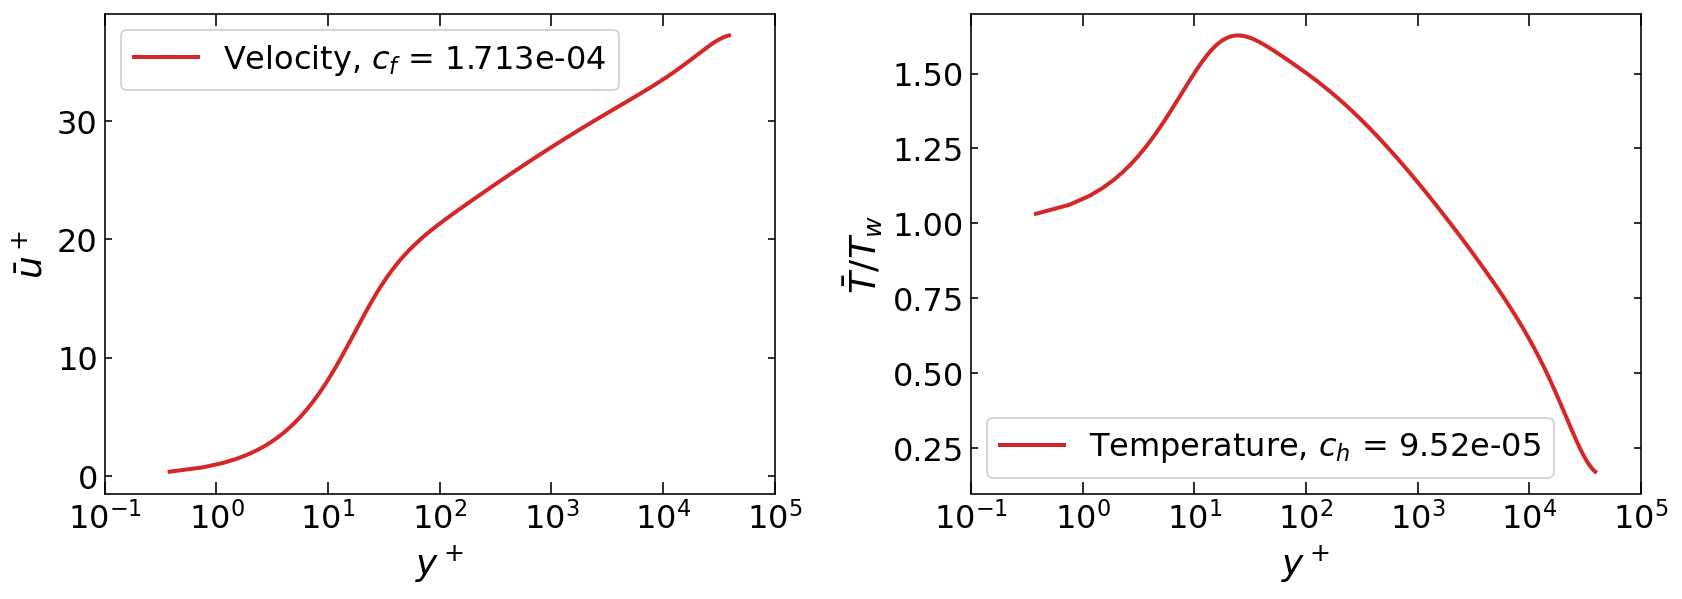

In [15]:
cf,ch,ReTau,MTau,ypl,yst,upl,T = solver(ReTheta  = 1.0e6, 
                                        Minf     = 15.0, 
                                        Tw_Tr    = 0.2,
                                        viscLaw  = "Sutherland", 
                                        Tinf_dim = 100.0, 
                                        gamma    = 1.4,
                                        Pr       = 0.72,
                                        sPr      = 0.8,
                                        kappa    = 0.41,
                                        Apl      = 17.0,
                                        y_ye     = grid(nPoints = 15000, stretch = 4),
                                        verbose  = True) 

print('\nResult: cf = {0:.5e}, ch = {1:.5e}, ReTau = {2:.5f}, MTau = {3:.3e}'.
      format(cf, ch, ReTau, MTau))



#################################################################################
#
# plot profiles
#
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('text', usetex=False)  # switch to True for latex font (might be slow)
rcParams.update({"xtick.major.size": 6, "xtick.minor.size": 3, "ytick.minor.size": 6, "ytick.minor.size": 3, 
                 'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True, 
                 'font.size': 16})


fig, ax = plt.subplots(1,2,figsize=(12,4.5))
ax[0].semilogx(ypl[1:],upl[1:], color='tab:red', lw=2, label="Velocity, $c_f$ = {:.3e}".format(cf))
ax[1].semilogx(ypl[1:],T[1:],   color='tab:red', lw=2, label="Temperature, $c_h$ = {:.2e}".format(ch))
ax[0].set_ylabel(r"$\bar u^+$",  fontsize = 18)
ax[1].set_ylabel(r"$\bar T/T_w$",fontsize = 18)
for a in ax:
    a.set_xticks(10.0**np.arange(-1, 6, 1))
    a.set_xlabel(r"$y^+$",fontsize = 18)
    a.legend()
plt.tight_layout()

# As example above but with range in $M_\infty=0...15$

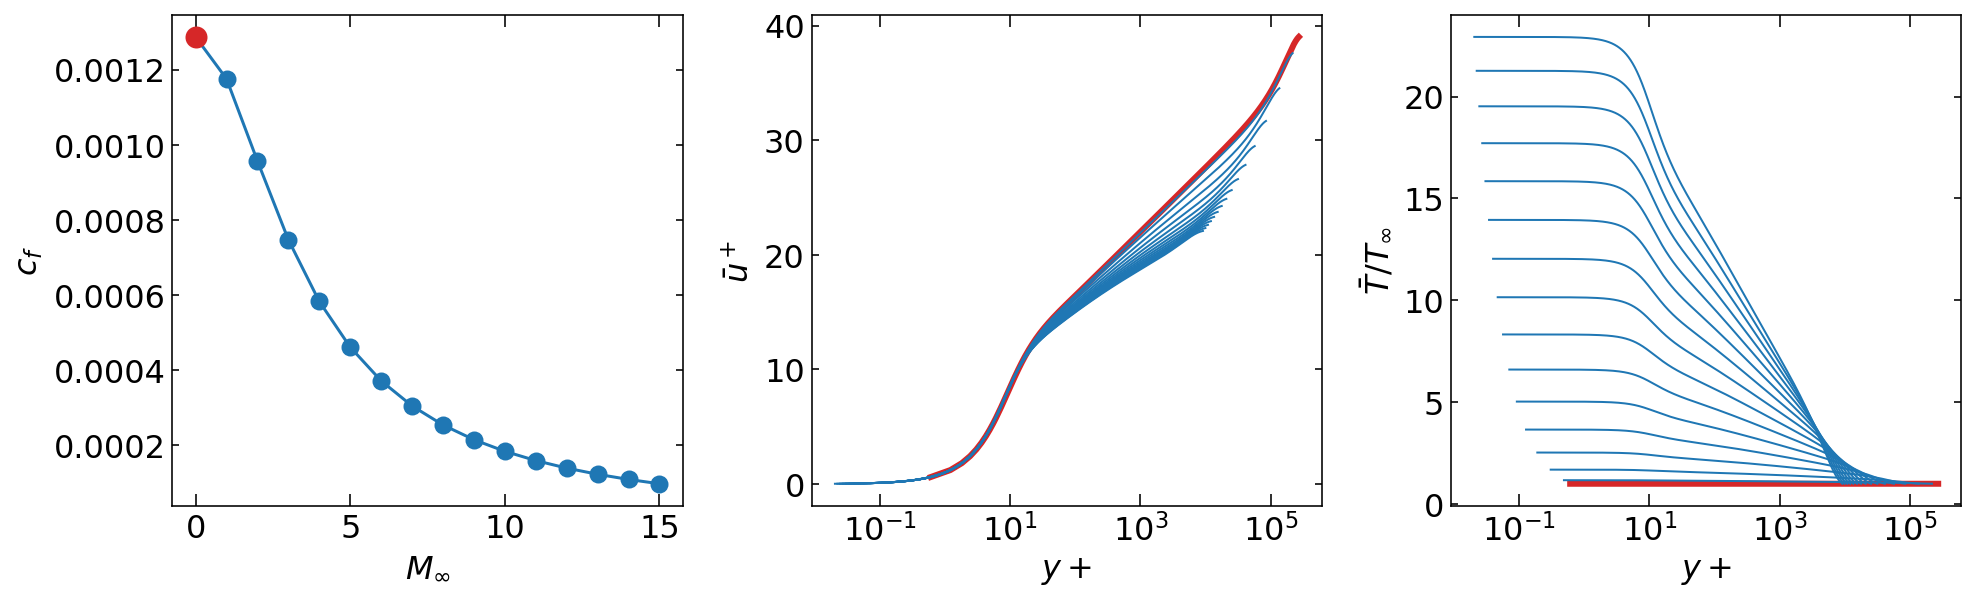

In [10]:
fig, ax = plt.subplots(1,3,figsize=(14,4.5))

Minf = np.arange(0.0, 15.1, 1)
cf   = np.zeros_like(Minf)

for i, M in enumerate(Minf):
    cf[i],_,_,_,ypl,_,upl,T = solver(y_ye = grid(nPoints = 20000, stretch = 5.5),
                                     ReTheta = 1.0e6, Minf = M, Tw_Tr = 1.0,
                                     viscLaw = "Sutherland", Tinf_dim = 100.0)

    color='tab:red' if i==0 else 'tab:blue'
    lw = 3 if i==0 else 1
    ax[1].semilogx(ypl[1:],upl[1:],     color=color, lw=lw)
    ax[2].semilogx(ypl[1:],T[1:]/T[-1], color=color, lw=lw)

ax[0].plot(Minf,    cf,    'o-', ms = 8,  color='tab:blue')
ax[0].plot(Minf[0], cf[0], 'o',  ms = 10, color='tab:red')

ax[0].set_xlabel(r"$M_\infty$"); ax[0].set_ylabel(r"$c_f$")
ax[1].set_xlabel(r"$y+$");       ax[1].set_ylabel(r"$\bar u^+$")
ax[2].set_xlabel(r"$y+$");       ax[2].set_ylabel(r"$\bar T/T_\infty$")
plt.tight_layout()

# As example above but with range in $T_w/T_r=0.2...1$

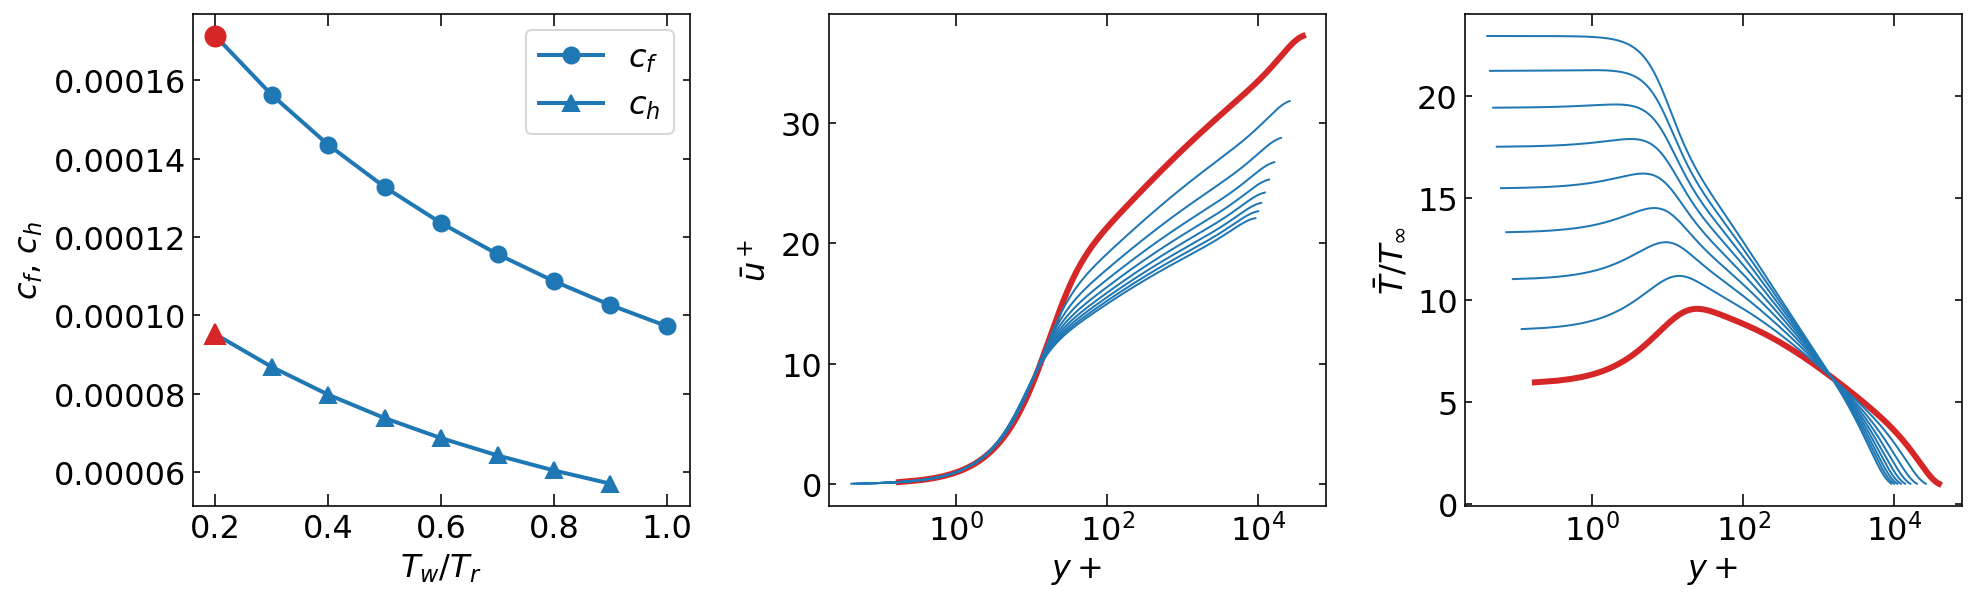

In [11]:
fig, ax = plt.subplots(1,3,figsize=(14,4.5))

Tw_Tr = np.arange(0.2, 1.01, 0.1)
cf    = np.zeros_like(Tw_Tr)
ch    = np.zeros_like(Tw_Tr)

for i, Tw in enumerate(Tw_Tr):
    cf[i],ch[i],_,_,ypl,_,upl,T = solver(y_ye = grid(nPoints = 10000, stretch = 5.5),
                                     ReTheta = 1.0e6, Minf = 15, Tw_Tr = Tw,
                                     viscLaw = "Sutherland", Tinf_dim = 100.0)

    color='tab:red' if i==0 else 'tab:blue'
    lw = 3 if i==0 else 1
    ax[1].semilogx(ypl[1:],upl[1:],     color=color, lw=lw)
    ax[2].semilogx(ypl[1:],T[1:]/T[-1], color=color, lw=lw)

ax[0].plot(Tw_Tr, cf, 'o-', lw = 2, ms = 8, color='tab:blue', label=r'$c_f$')
ax[0].plot(Tw_Tr[:-1], ch[:-1], '^-', lw = 2, ms = 8, color='tab:blue', label=r'$c_h$')
ax[0].plot(Tw_Tr[0], cf[0], 'o', color='tab:red', ms = 10)
ax[0].plot(Tw_Tr[0], ch[0], '^', color='tab:red', ms = 10)
ax[0].legend()

ax[0].set_xlabel(r"$T_w/T_r$");  ax[0].set_ylabel(r"$c_f$, $c_h$")
ax[1].set_xlabel(r"$y+$");       ax[1].set_ylabel(r"$\bar u^+$")
ax[2].set_xlabel(r"$y+$");       ax[2].set_ylabel(r"$\bar T/T_\infty$")
plt.tight_layout()

# As example above but with range in $Re_{\theta}=1e5...1e7$


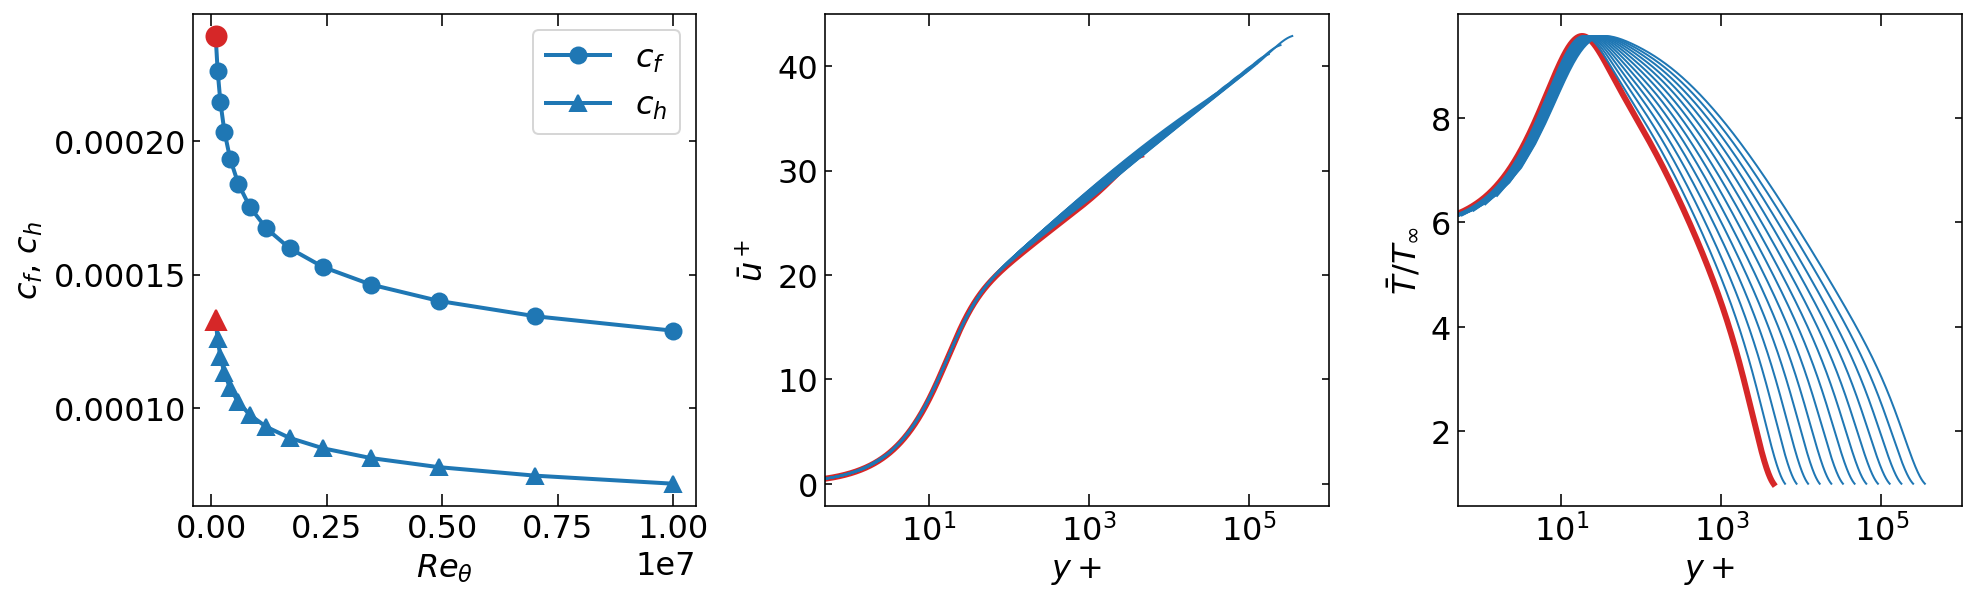

In [12]:
fig, ax = plt.subplots(1,3,figsize=(14,4.5))

ReTheta = 10**np.linspace(np.log10(1e5), np.log10(1e7),14)
cf      = np.zeros_like(ReTheta)
ch      = np.zeros_like(ReTheta)

for i, Re in enumerate(ReTheta):
    cf[i],ch[i],_,_,ypl,_,upl,T = solver(y_ye = grid(nPoints = 10000, stretch = 5.5),
                                     ReTheta = Re, Minf = 15, Tw_Tr = 0.2,
                                     viscLaw = "Sutherland", Tinf_dim = 100.0)

    color='tab:red' if i==0 else 'tab:blue'
    lw = 3 if i==0 else 1
    ax[1].semilogx(ypl[1:],upl[1:],     color=color, lw=lw)
    ax[2].semilogx(ypl[1:],T[1:]/T[-1], color=color, lw=lw)

ax[0].plot(ReTheta, cf, 'o-', lw = 2, ms = 8, color='tab:blue', label=r'$c_f$')
ax[0].plot(ReTheta, ch, '^-', lw = 2, ms = 8, color='tab:blue', label=r'$c_h$')
ax[0].plot(ReTheta[0], cf[0], 'o', color='tab:red', ms = 10)
ax[0].plot(ReTheta[0], ch[0], '^', color='tab:red', ms = 10)
ax[0].legend()

ax[0].set_xlabel(r"$Re_{\theta}$");  ax[0].set_ylabel(r"$c_f$, $c_h$")
ax[1].set_xlabel(r"$y+$");           ax[1].set_ylabel(r"$\bar u^+$")
ax[2].set_xlabel(r"$y+$");           ax[2].set_ylabel(r"$\bar T/T_\infty$")
ax[1].set_xlim(0.51,1e6);ax[2].set_xlim(0.51,1e6)
plt.tight_layout()

<br>
<br>
<br>

# Validation of $c_f$ and $c_h$ estimates with various DNS cases from literature
<br>

<hr style="border:0.5px solid black">

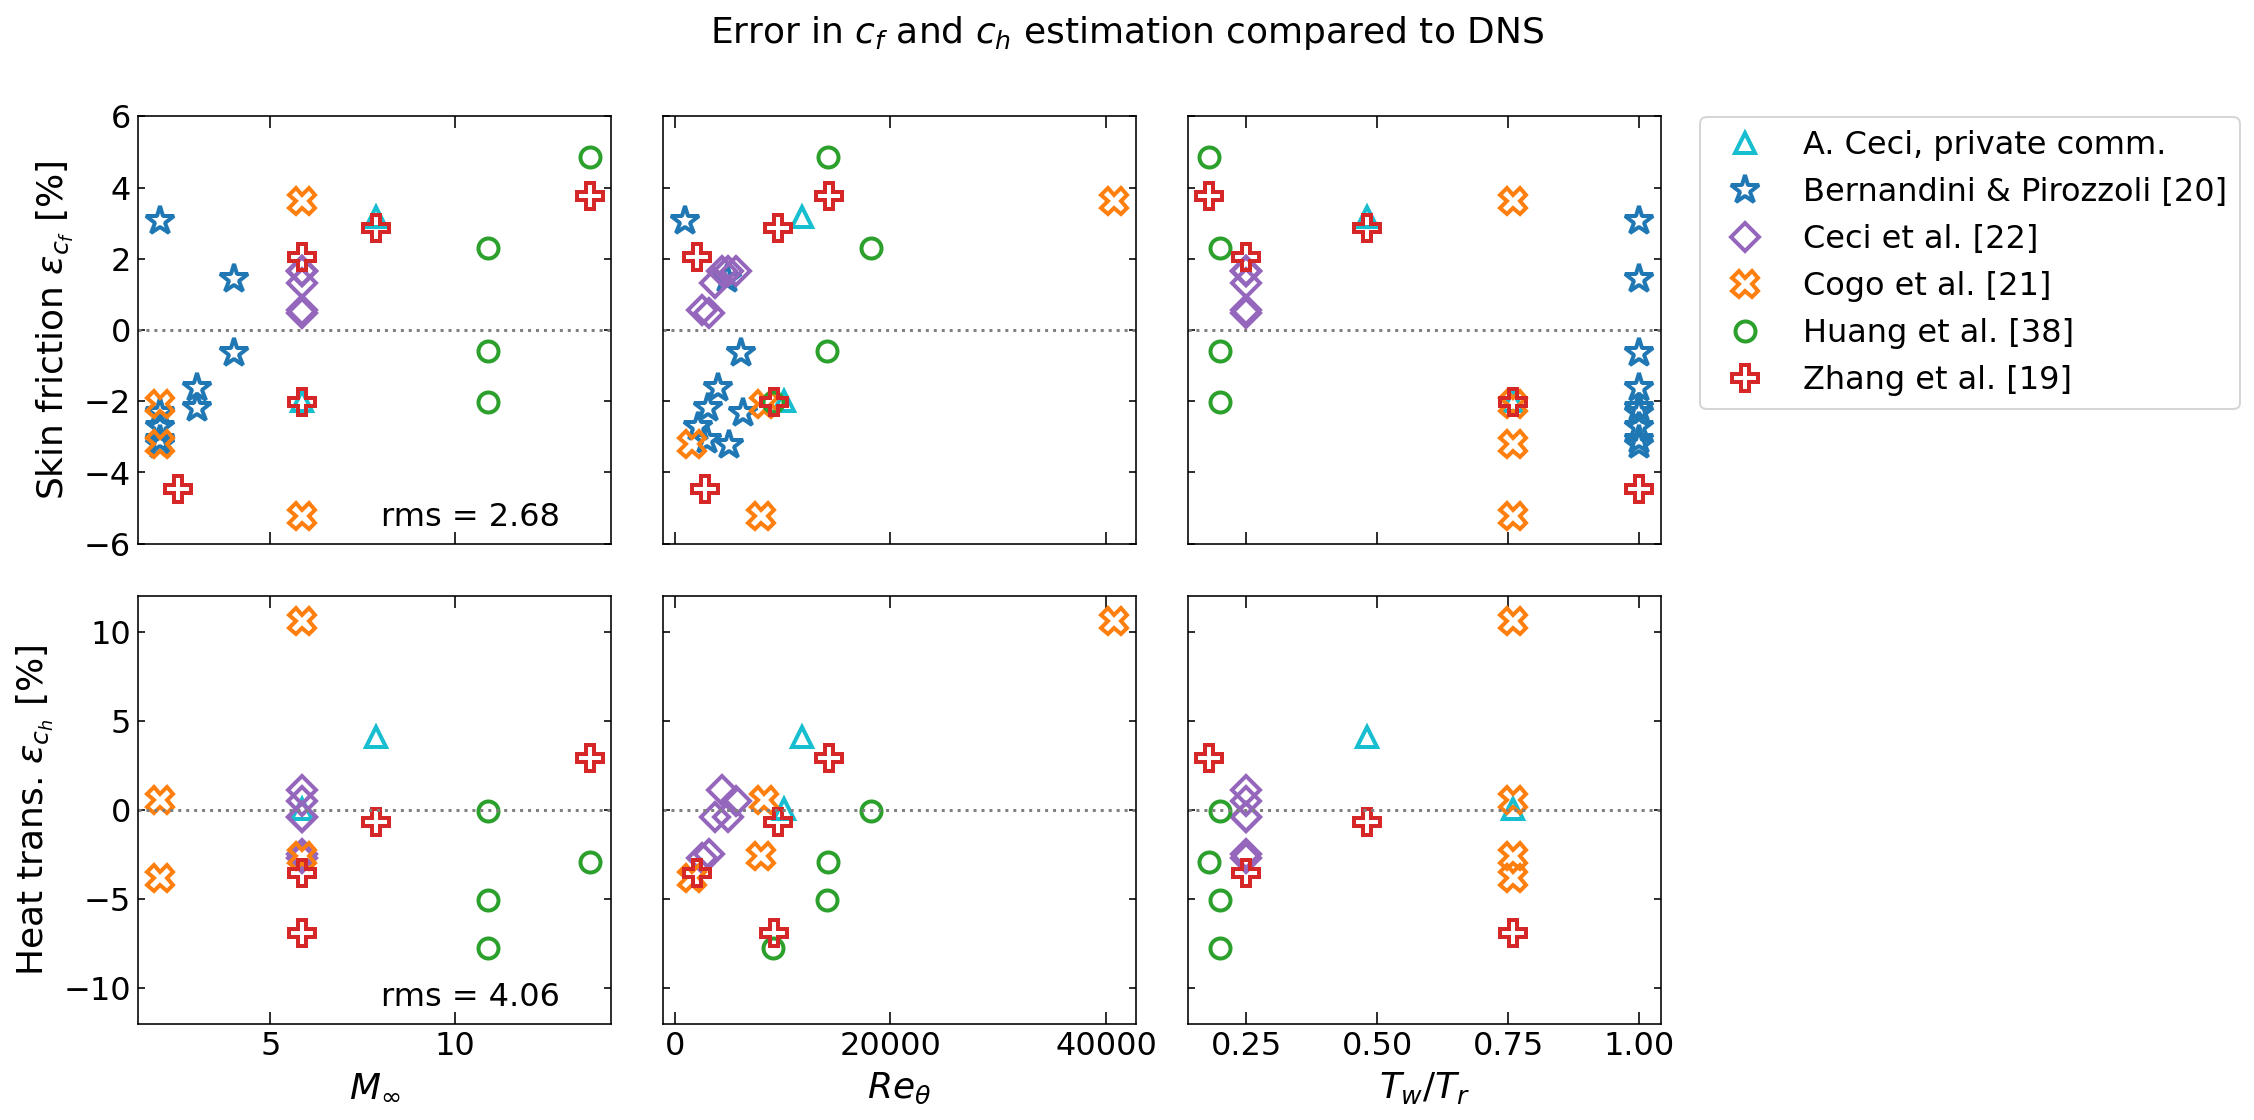

In [17]:
import pandas as pd
url='https://raw.githubusercontent.com/Fluid-Dynamics-Of-Energy-Systems-Team/DragAndHeatTransferEstimation/master/DNSdata/DataForDragAndHeatTransfer.csv'
DNS = pd.read_csv(url)
groups = DNS.groupby('Author', as_index=True)

cf_rms = 0.0
ch_rms = 0.0

fig, ax = plt.subplots(2,3, figsize=(16,8), sharex='col', sharey='row')

for group_name, group in groups:
    for row_index, row in group.reset_index().iterrows():

        label = None
        if row_index == 0:
            label = row['Author']

        cf,ch,_,_,_,_,_,_ = solver(ReTheta = row['ReTheta'], Minf = row['Minf'], Tw_Tr = row['Tw_Tr'],
                                   viscLaw = row['ViscLaw'], Tinf_dim = row['Tinf'])

        cf_err  = (cf-row['cf_DNS'])/row['cf_DNS']*100
        ch_err  = (ch-row['ch_DNS'])/row['ch_DNS']*100
        
        cf_rms += cf_err**2
        ch_rms  = np.nansum([ch_rms,ch_err**2])

        params = {"marker": row['Symbol'], "color": row['Color'], "ms": 10*row['Size'], 
                  "mew": 2, "fillstyle": 'none', "linestyle": 'None', "label": label}
        
        ax[0,0].plot(row['Minf'],    cf_err, **params)
        ax[0,1].plot(row['ReTheta'], cf_err, **params)
        ax[0,2].plot(row['Tw_Tr'],   cf_err, **params)
        
        ax[1,0].plot(row['Minf'],    ch_err, **params)
        ax[1,1].plot(row['ReTheta'], ch_err, **params)
        ax[1,2].plot(row['Tw_Tr'],   ch_err, **params)

cf_rms = np.sqrt(cf_rms/DNS["cf_DNS"].count())
ch_rms = np.sqrt(ch_rms/DNS["ch_DNS"].count())

ax[0,0].text(8,-5.5, "rms = " + str(round(cf_rms,2)))
ax[1,0].text(8,-11,  "rms = " + str(round(ch_rms,2)))
ax[0,0].set_ylabel(r"Skin friction $\varepsilon_{c_f}~[\%]$",fontsize = 18)
ax[1,0].set_ylabel(r"Heat trans. $\varepsilon_{c_h}~[\%]$",fontsize = 18)
ax[1,0].set_xlabel(r"$M_\infty$",fontsize = 18)
ax[1,1].set_xlabel(r"$Re_\theta$",fontsize = 18)
ax[1,2].set_xlabel(r"$T_w/T_r$",fontsize = 18)

ax[0,0].set_ylim([-6, 6])
ax[1,0].set_ylim([-12, 12])

for a in ax.reshape(-1):
    a.axhline(y=0, color="gray", linestyle=":")

ax[0,2].legend(bbox_to_anchor=(1.05, 1.035))

fig.suptitle(r"Error in $c_f$ and $c_h$ estimation compared to DNS", fontsize = 18)
plt.tight_layout()

## Plot estimated velocity and temperature profiles for these cases

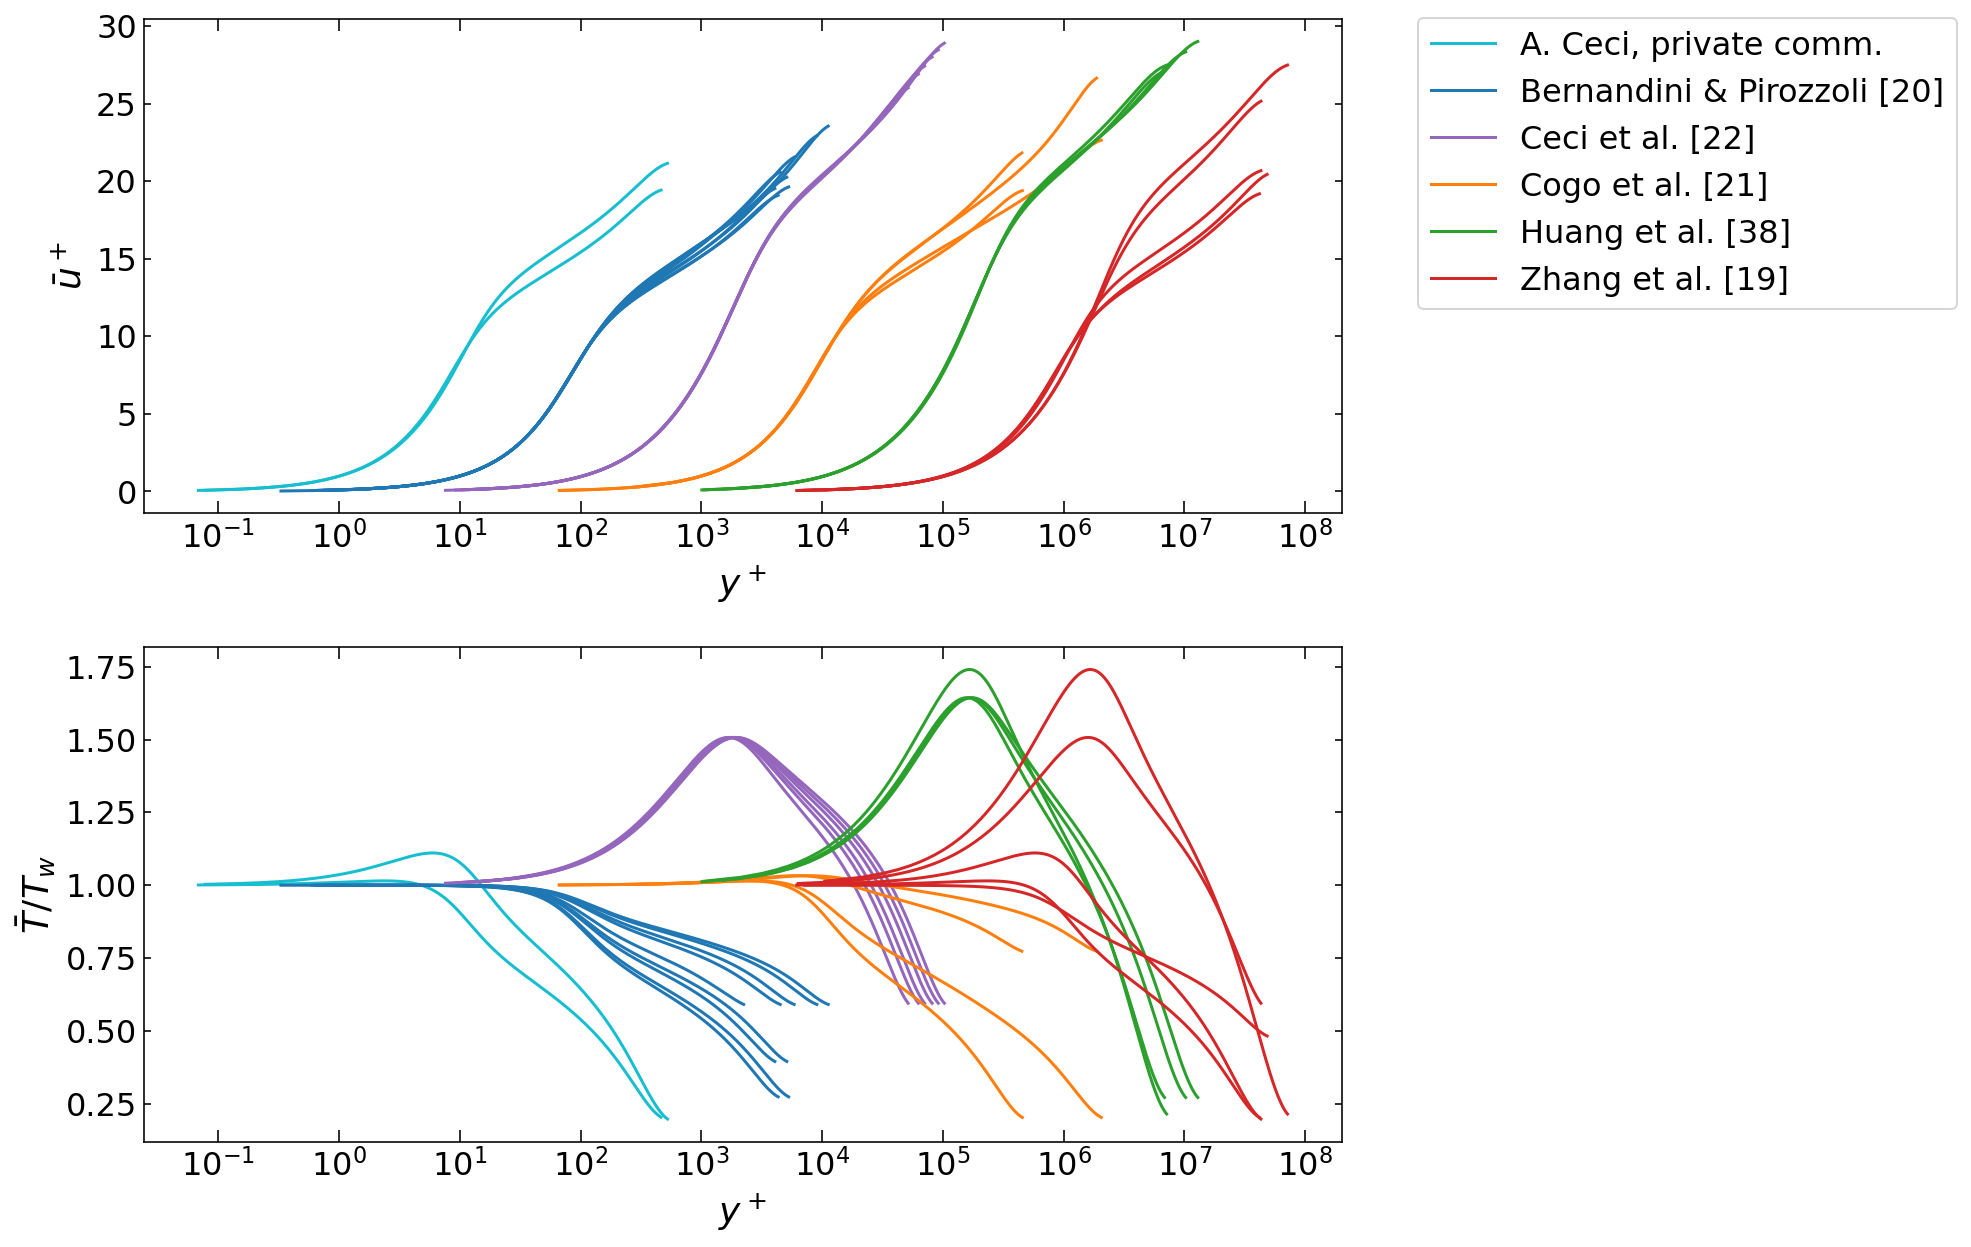

In [14]:
fig, ax = plt.subplots(2,1,figsize=(14,9))

mult_x = 0.1

for group_name, group in groups:
    for row_index, row in group.reset_index().iterrows():

        label = None
        if row_index == 0:
            label = row['Author']
            mult_x *= 10

        _,_,_,_,ypl, yst, upl, T_Tw = solver(ReTheta  = row['ReTheta'], Minf  = row['Minf'], 
                                             Tw_Tr    = row['Tw_Tr'], viscLaw = row['ViscLaw'], 
                                             Tinf_dim = row['Tinf'])

        ax[0].semilogx(ypl[1:]*mult_x, upl[1:],  color = row['Color'], label=label)
        ax[1].semilogx(ypl[1:]*mult_x, T_Tw[1:], color = row['Color'], label=label)

ax[0].set_ylabel(r"$\bar u^+$",   fontsize = 18)
ax[1].set_ylabel(r"$\bar T/T_w$", fontsize = 18)

for a in ax:
    a.set_xticks(10.0**np.arange(-1, 9, 1))
    a.set_xlabel(r"$y^+$",      fontsize = 18)

ax[0].legend(bbox_to_anchor=(1.05, 1.035))

plt.tight_layout()